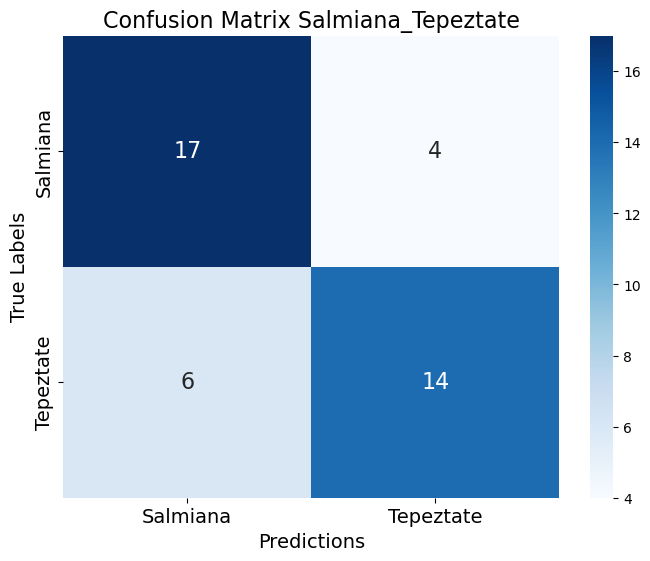

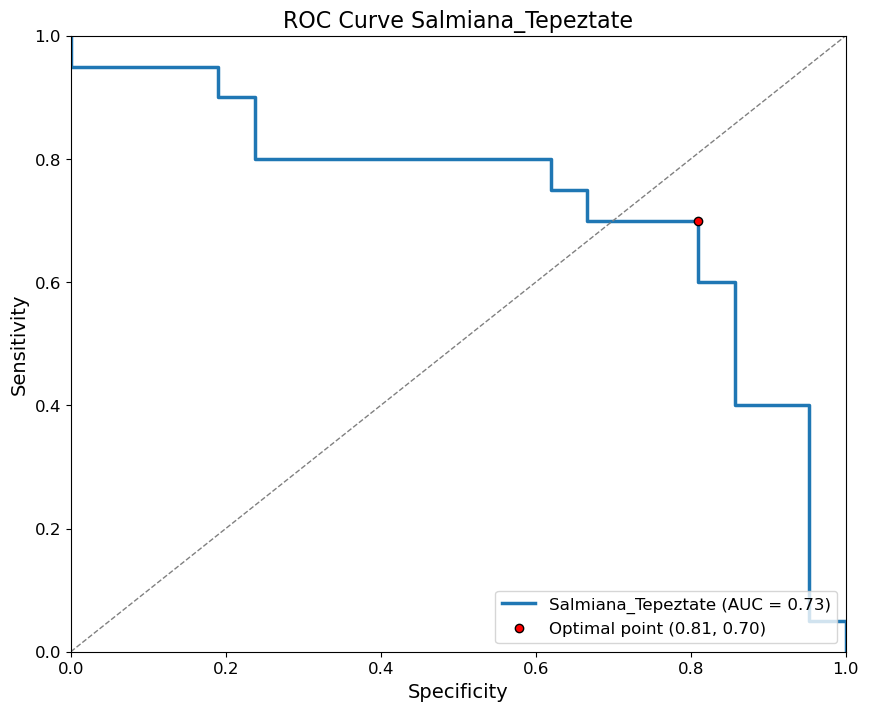

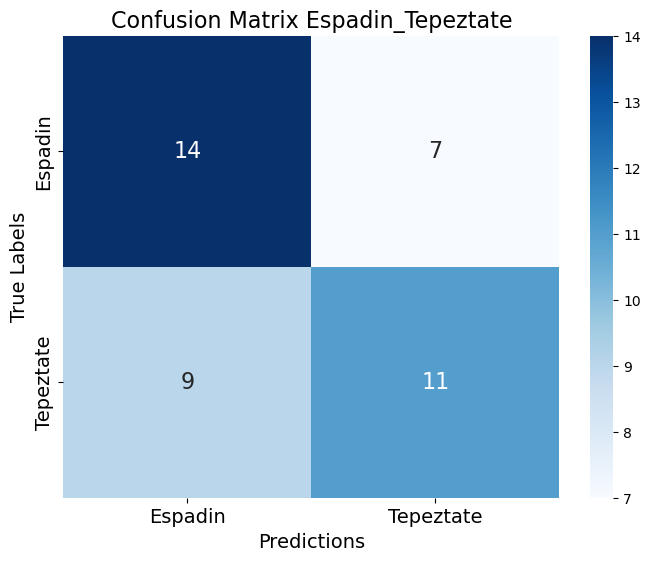

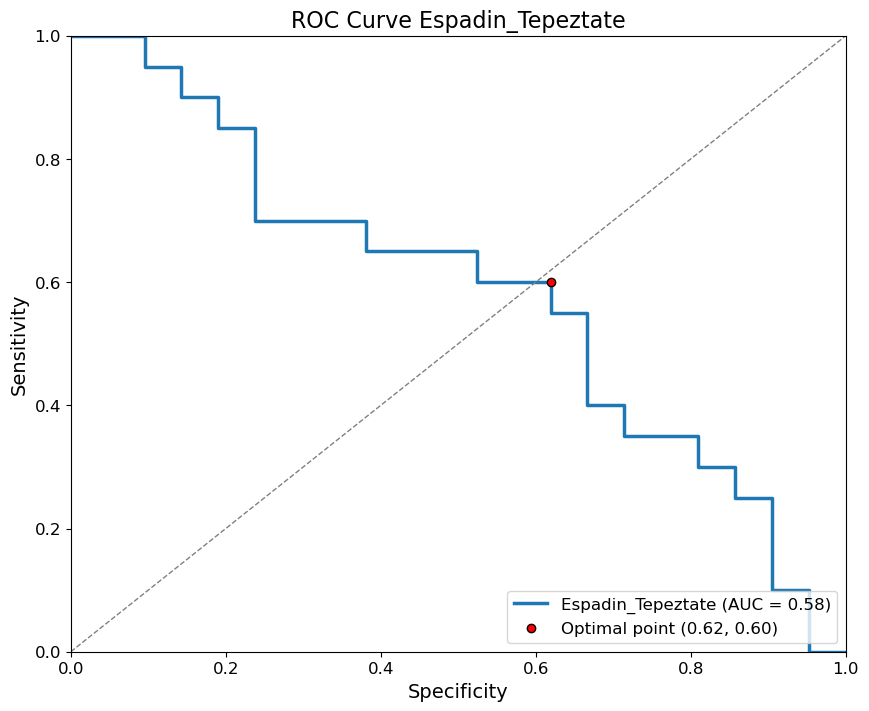

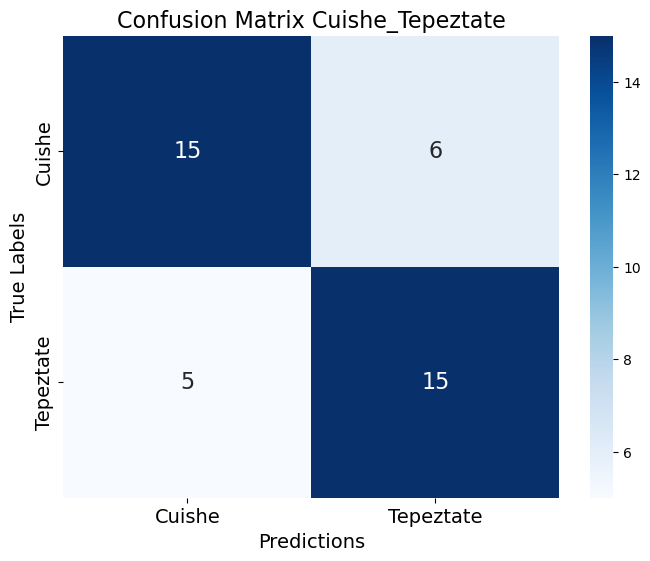

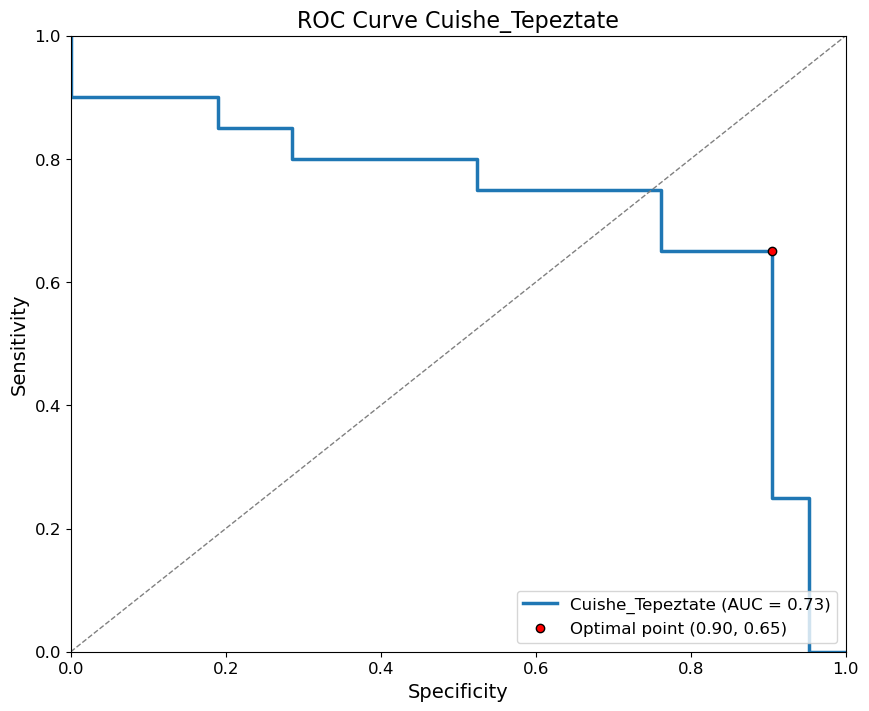

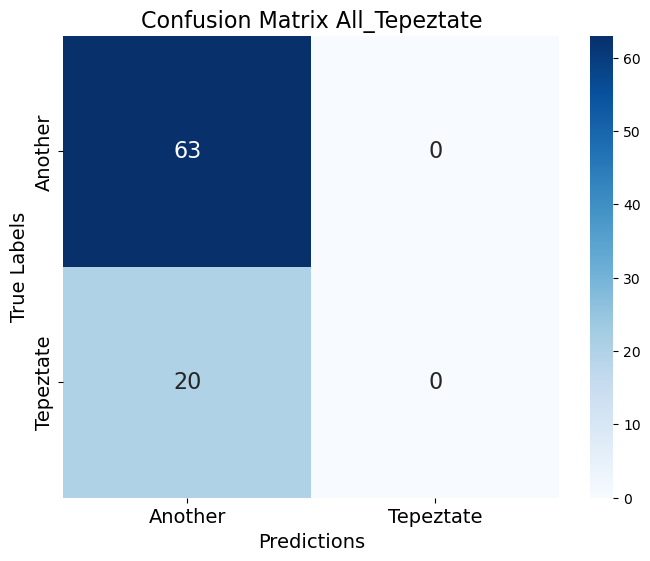

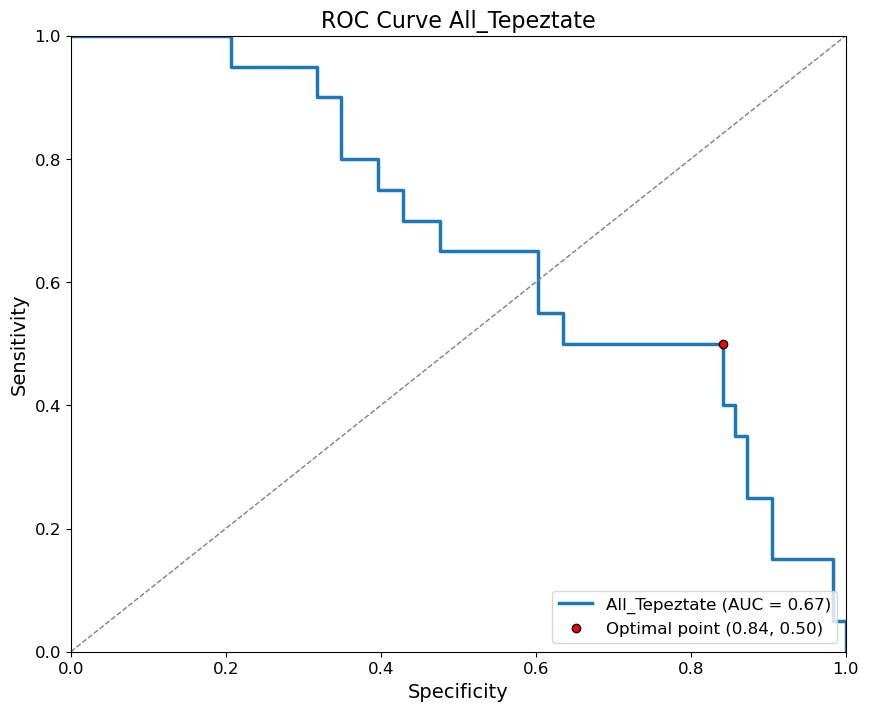

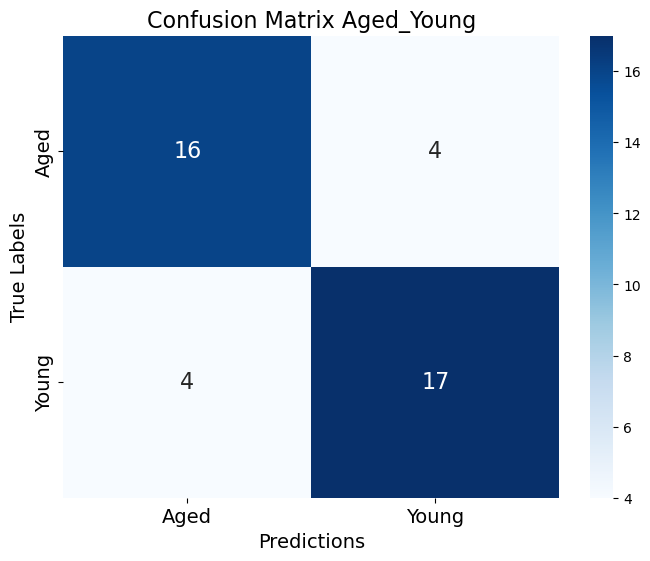

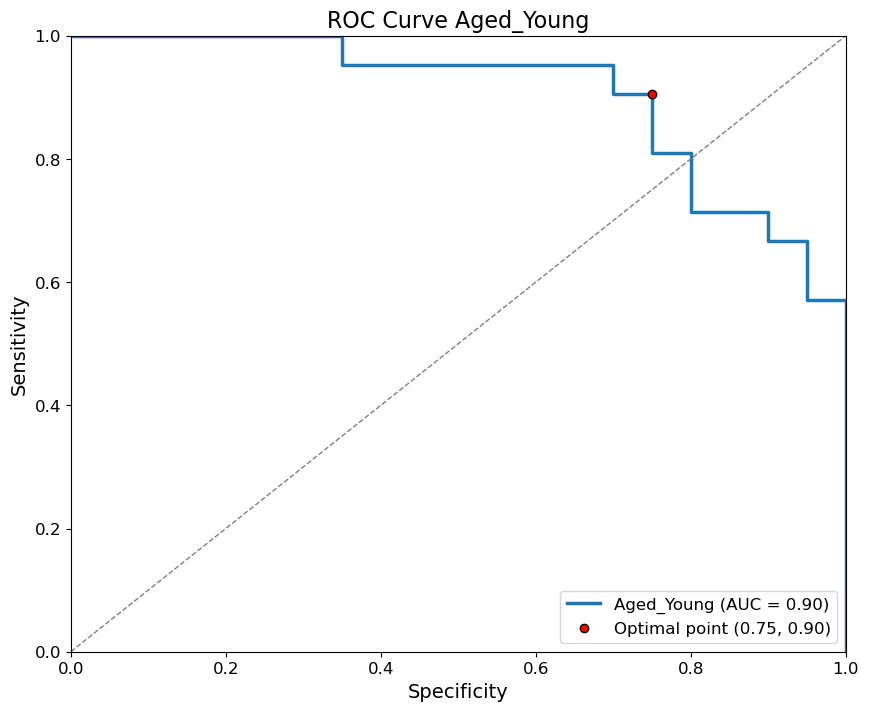

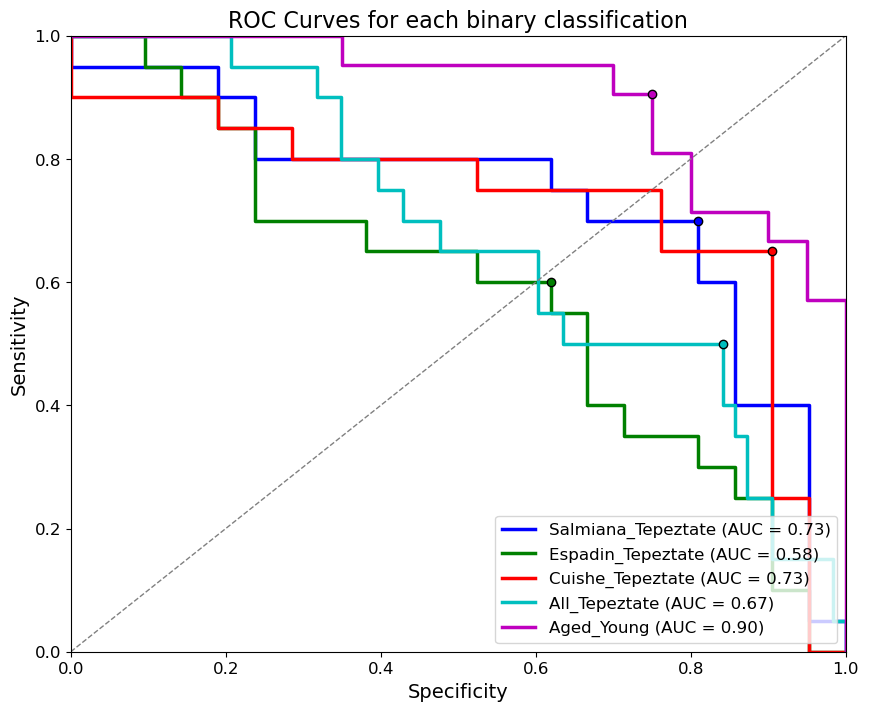

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import joblib

ActualFolder = (r'C:\Users\invitados fc\Documents\Files JCTG\2025 Mezcales\Codes Modify - Alternatives\Best Results 2')

os.chdir(ActualFolder)


# Carga los modelos y las etiquetas
modelos = {
    "Salmiana_Tepeztate": joblib.load('Salmiana_Tepeztate_best_svm_model.joblib'),
    "Espadin_Tepeztate": joblib.load('Espadin_Tepeztate_best_svm_model.joblib'),
    "Cuishe_Tepeztate": joblib.load('Cuishe_Tepeztate_best_svm_model.joblib'),
    "All_Tepeztate": joblib.load('All_Tepeztate_best_svm_model.joblib'),
    "Aged_Young": joblib.load('Aged_Young_best_svm_model.joblib'),
}

# Etiquetas para cada modelo
labels = {
    "Salmiana_Tepeztate": ["Salmiana", "Tepeztate"],
    "Espadin_Tepeztate": ["Espadin", "Tepeztate"],
    "Cuishe_Tepeztate": ["Cuishe", "Tepeztate"],
    "All_Tepeztate": ["Another", "Tepeztate"],  # Ajusta según sea necesario
    "Aged_Young": ["Aged", "Young"],
}



# Paths a los folders de validación
validation_folders = {
    "Salmiana_Tepeztate": r'C:\Users\invitados fc\Documents\Files JCTG\2025 Mezcales\Images\Salmiana vs Tepeztate\val',
    "Espadin_Tepeztate": r'C:\Users\invitados fc\Documents\Files JCTG\2025 Mezcales\Images\Espadin vs Tepeztate\val',
    "Cuishe_Tepeztate": r'C:\Users\invitados fc\Documents\Files JCTG\2025 Mezcales\Images\Cuishe vs Tepeztate\val',
    "All_Tepeztate": r'C:\Users\invitados fc\Documents\Files JCTG\2025 Mezcales\Images\All vs Tepeztate\val',
    "Aged_Young": r'C:\Users\invitados fc\Documents\Files JCTG\2025 Mezcales\Images\Aged vs Young\val',
}



# Función para cargar imágenes de validación
def load_validation_images(folder, model_name):
    validation_images = []
    validation_labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for image_file in os.listdir(label_path):
            img = load_img(os.path.join(label_path, image_file), target_size=(224, 224))
            img_array = img_to_array(img)
            validation_images.append(img_array)
            validation_labels.append(label)
    validation_images = np.array(validation_images)
    validation_images = validation_images.reshape(-1, 224 * 224 * 3)
    le = joblib.load(f'{model_name}_label_encoder.joblib')
    validation_labels = le.transform(validation_labels)
    return validation_images, validation_labels

# Función para plotear la matriz de confusión
def plot_confusion_matrix(y_test, y_pred, labels, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels, annot_kws={"fontsize": 16})
    plt.xlabel("Predictions", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(f"Confusion Matrix {model_name}", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f"{model_name}_confusion_matrix.png", dpi=900)
    plt.show()

# Función para plotear la curva ROC
def plot_roc_curve(y_test, y_pred_proba, model_name, labels, save=False):
    if len(np.unique(y_test)) == 2:  # Binario
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
        auc_value = auc(fpr, tpr)
        optimal_idx = np.argmax(tpr - fpr)
        
        plt.figure(figsize=(10, 8))
        plt.plot(1 - fpr, tpr, label=f"{model_name} (AUC = {auc_value:.2f})", linewidth=2.5)
        plt.plot(1 - fpr[optimal_idx], tpr[optimal_idx], 'o', markerfacecolor='red', markeredgecolor='black', label=f"Optimal point ({1 - fpr[optimal_idx]:.2f}, {tpr[optimal_idx]:.2f})")
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
        plt.xlabel("Specificity", fontsize=14)
        plt.ylabel("Sensitivity", fontsize=14)
        plt.title(f"ROC Curve {model_name}", fontsize=16)
        plt.legend(loc="lower right", fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        if save:
            plt.savefig(f"{model_name}_roc_curve.png", dpi=900, bbox_inches='tight')
        plt.show()



# Plotear matrices de confusión y curvas ROC para cada modelo
for model_name, model in modelos.items():
    validation_images, validation_labels = load_validation_images(validation_folders[model_name], model_name)
    y_pred = model.predict(validation_images)
    try:
        y_pred_proba = model.decision_function(validation_images)
    except AttributeError:
        y_pred_proba = model.predict_proba(validation_images)

    plot_confusion_matrix(validation_labels, y_pred, labels[model_name], model_name)

    if len(np.unique(validation_labels)) == 2:  # Binario
        plot_roc_curve(validation_labels, np.column_stack((-y_pred_proba, y_pred_proba)) if y_pred_proba.ndim == 1 else y_pred_proba, model_name, labels[model_name], save=True)
    else:  # Multiclase
        plot_roc_curve(validation_labels, y_pred_proba, model_name, labels[model_name], save=True)


# Plotear curvas ROC para todas las clasificaciones binarias
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm']
for i, (model_name, model) in enumerate(modelos.items()):
    validation_images, validation_labels = load_validation_images(validation_folders[model_name], model_name)
    if len(np.unique(validation_labels)) == 2:
        y_pred = model.predict(validation_images)
        try:
            y_pred_proba = model.decision_function(validation_images)
        except AttributeError:
            y_pred_proba = model.predict_proba(validation_images)
        if y_pred_proba.ndim == 1:
            y_pred_proba = np.column_stack((-y_pred_proba, y_pred_proba))
        fpr, tpr, thresholds = roc_curve(validation_labels, y_pred_proba[:, 1])
        auc_value = auc(fpr, tpr)
        optimal_idx = np.argmax(tpr - fpr)
        
        ax.plot(1 - fpr, tpr, label=f"{model_name} (AUC = {auc_value:.2f})", linewidth=2.5, color=colors[i % len(colors)])
        ax.plot(1 - fpr[optimal_idx], tpr[optimal_idx], 'o', markerfacecolor=colors[i % len(colors)], markeredgecolor='black')

ax.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
ax.set_xlabel("Specificity", fontsize=14)
ax.set_ylabel("Sensitivity", fontsize=14)
ax.set_title("ROC Curves for each binary classification", fontsize=16)
ax.legend(loc="lower right", fontsize=12)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("all_models_roc_curve.png", dpi=900, bbox_inches='tight')
plt.show()